## Transport Coefficient Calculations on Ni-X (X = Cr, Fe)

### Data was obtained from Tucker et. al.  - Journal of Nuclear Materials405, 216–234 (2010)

### Note - due to discrepancies in binding energies (as discussed in our paper), we did not consider any electronic contributions to binding energies. Only electronic contributions to migration barriers were considered. 

In [1]:
from onsager.crystal import Crystal
from onsager.crystalStars import zeroclean
from onsager.OnsagerCalc import dumbbellMediated
from onsager.crystal import DB_disp, DB_disp4 #, pureDBContainer, mixedDBContainer
# from onsager.DB_structs import dumbbell, SdPair, jump, connector
import pickle
import numpy as np
from scipy.constants import physical_constants
kB = physical_constants['Boltzmann constant in eV/K'][0]
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm

### We work with our existing Onsager Calculator that we had saved as a pickled object. This allows for reuse in case multiple uses are required.

In [2]:
with open('NiFe_NiCr_Onsg.pkl','rb') as fl:
    onsagercalculator = pickle.load(fl)

pdbcontainer_Ni = onsagercalculator.pdbcontainer
mdbcontainer_Ni = onsagercalculator.mdbcontainer

# The pdbcontainer and mdbcontainer objects (see states.py) contain all information regarding pure and
# mixed dumbbells, including: The possible orientations (pdbcontainer.iorlist), the symmetry grouping
# of the dumbbells (pdbcontainer.symorlist) and the group operations between them.

# The following output shows the Nickel crystal (all units are nano-meters)
print(onsagercalculator.crys)

#Lattice:
  a1 = [0.    0.176 0.176]
  a2 = [0.176 0.    0.176]
  a3 = [0.176 0.176 0.   ]
#Basis:
  (Ni) 0.0 = [0. 0. 0.]


### Next, we need to identify the solute-dumbbell complex states we are dealing with. The definitions of a-type and b-type complex states can be found in Tucker et. al. We pre-identify them and note the indices assigned to them, so that we can assign energies to them later on

In [3]:
# First, we need to figure out the interacting complexes, whether they are "orign states", a-type or b-type
# origin state is where solute and pure dumbbell are in the same position - unphysical

# In the output, each set of 4 lines correspond to the following
# The first line - the index of the symmetry group containing the particular type of complex state.
# The second line - the relative cartesian location of the dumbbell compared to the solute
# The third line - the orientation vector of the dumbbell
# The fourth line - the number of complex states of that type.

# Note that the orientation vector is a nominal vector. It helps in symmetry analysis and
# identificiation of jump types, but atomic displacements are only considered to be site-to-site.
# To keep things somewhat physically relevant, we choose this orientation vector length to be the same
# as the host atomic diameter (0.326 nm for Ni).

count = 0
for star in onsagercalculator.thermo.stars[:onsagercalculator.thermo.mixedstartindex]:
    # Iterate through all symmetry groups of complex states
    print(count) # the symmetry group index assigned for this type of complex state.
    
    st0 = star[0]  # the first complex state (representative) of a symmetry group
    
    # print the cartesian position vector of the solute
    print(np.dot(onsagercalculator.crys.lattice, st0.db.R))
    
    # print the cartesian position vector of the solute
    print(onsagercalculator.pdbcontainer.iorlist[star[0].db.iorind][1])
    print(len(star))
    count += 1
    print()

0
[0. 0. 0.]
[0.326 0.    0.   ]
3

1
[ 0.176 -0.176  0.   ]
[0.326 0.    0.   ]
24

2
[0.176 0.    0.176]
[ 0.    -0.326  0.   ]
12



## Next, we need to identify the omega1 jump types we are dealing with

In [4]:
# First, let us weed out jumps to and from "origin" states (see our paper)
# "Origin" states are where the solute and pure dumbbell are at the same site - which is unphysical.
# There should be two kinds - one to and from origin states and the second on-site rotation in an origin state

# For a dumbbell, the (i, or) indices (iorInd) correspond to (basis site, orientation vector) pairs.
# The corresponding values can be found at onsagercalculator.pdbcontainer.iorlist[iorInd]

# The basis index of the solute corresponds to which unit cell site type it occupies.

# The quantity "c1" indicates whether the atom at the head (c1 = 1) or the tail (c1 = -1) of the
# orientation vector is executing the jump

# The quantity "c2" indicates whether the jumping atom ends up at the head (c2 = 1) or the 
# tail (c2 = -1) of the final orientation vector.

origin_index = []
for idx, jlist in enumerate(onsagercalculator.jnet1):
    if jlist[0].state2.is_zero(onsagercalculator.pdbcontainer):
        print("Origin state omega1 jump type index : {}".format(idx))
        print(jlist[0])
        origin_index.append(idx)
        print()
        continue
    if jlist[0].state1.is_zero(onsagercalculator.pdbcontainer):
        print("Origin state omega1 jump type index : {}".format(idx))
        print(jlist[0])
        origin_index.append(idx)
        print()
        continue

print(origin_index)

Origin state omega1 jump type index : 0
Jump object:
Initial state:
	Solute loctation:basis index = 0, lattice vector = [0 0 0]
	dumbbell : (i, or) index = 0, lattice vector = [0 0 0]
Final state:
	Solute loctation :basis index = 0, lattice vector = [0 0 0]
	dumbbell : (i, or) index = 1, lattice vector = [ 0  1 -1]
Jumping from c1 = 1 to c2 = -1

Origin state omega1 jump type index : 13
Jump object:
Initial state:
	Solute loctation:basis index = 0, lattice vector = [0 0 0]
	dumbbell : (i, or) index = 0, lattice vector = [0 0 0]
Final state:
	Solute loctation :basis index = 0, lattice vector = [0 0 0]
	dumbbell : (i, or) index = 1, lattice vector = [0 0 0]
Jumping from c1 = 1 to c2 = 1

[0, 13]


In [5]:
## In order to make this a bit less tedious, let's first filter out the rotation jumps
rot_index = []

# iterate through the omega1 jump types (which are grouped by symmetry)
for i, jlist in enumerate(onsagercalculator.jnet1):
    jmp = jlist[0] # Get a representative jump
    
    # check the dumbbell displacement during the jump
    dx = DB_disp(pdbcontainer_Ni, jmp.state1, jmp.state2) # the disp function is in states.py
    
    # if the displacement is zero, then we have a rotation
    # if the rotation is of an origin state, ignore it, since we have identified it before.
    if np.allclose(dx, 0.) and not i in origin_index:
        rot_index.append(i)
print(rot_index)

[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


## Identification of roto-translational omega1 jumps to compare to Tucker et. al.

In [6]:
## we have to see what the omega1 jump network looks like, once we have weeded out the rotations and
## origin state jumps

# In the outputs of this cell, each set of six line corresponds to the following

# First line: the symmetry group index of the jumps. All jumps are related by symmetry are stored
# in the same list. Since Forward and Backward jumps have the same transition state energy, they are also
# stored in the same list.

# Second line : the initial location of the dumbbell relative to the solute atom

# Third line : the initial orientation vector of the dumbbell and the integer
# c1 (-1 if the atom at the tail of the orientation vector jumps, 1 if the head atom jumps)

# Fourth line : A blank line

# Fifth line : the final location of the dumbbell relative to the solute atom

# Sixth line : the final orientation vector of the dumbbell and the integer
# c2 (-1 if the jumping atom arrives at the tail of the orientation vector, 1 if at the head)


# These jumps need to be then compared with the jump types given in
# Tucker et. al. (see begining of notebook for reference), and then migration energies 
# assigned accordingly later on.
# All jumps that are grouped within the same symmetry group (indexed by the first number) - will
# have the migration same energy.

# Note that if every time a new pickle file is created by regenerating the onsager calculator, the indices
# assigned to particular jump types may change and they have to be re-identified from Tucker et. al.

for i, jlist in enumerate(onsagercalculator.jnet1):
    if not i in rot_index and not i in origin_index:
        jmp = jlist[0]
        print(i)
        print(np.dot(onsagercalculator.crys.lattice, jmp.state1.db.R))
        print(pdbcontainer_Ni.iorlist[jmp.state1.db.iorind][1], jmp.c1)
        print()
        print(np.dot(onsagercalculator.crys.lattice, jmp.state2.db.R))
        print(pdbcontainer_Ni.iorlist[jmp.state2.db.iorind][1], jmp.c2)
        print()
        print()

1
[ 0.    -0.176  0.176]
[0.    0.    0.326] 1

[ 0.    -0.352  0.352]
[ 0.    -0.326  0.   ] -1


2
[0.176 0.    0.176]
[0.    0.    0.326] 1

[ 0.176 -0.176  0.352]
[ 0.    -0.326  0.   ] -1


3
[ 0.176  0.    -0.176]
[0.    0.    0.326] 1

[ 0.176 -0.176  0.   ]
[ 0.    -0.326  0.   ] -1


4
[0.176 0.176 0.   ]
[0.    0.    0.326] 1

[0.176 0.    0.176]
[ 0.    -0.326  0.   ] -1


5
[-0.176 -0.176  0.   ]
[0.    0.    0.326] 1

[-0.176 -0.352  0.176]
[ 0.    -0.326  0.   ] -1


6
[ 0.    -0.176 -0.176]
[0.    0.    0.326] 1

[ 0.    -0.352  0.   ]
[ 0.    -0.326  0.   ] -1


7
[0.    0.176 0.176]
[0.    0.    0.326] 1

[0.    0.    0.352]
[ 0.    -0.326  0.   ] -1


8
[-0.352  0.     0.   ]
[0.    0.    0.326] 1

[-0.352 -0.176  0.176]
[ 0.    -0.326  0.   ] -1


9
[-0.352  0.176  0.176]
[0.    0.    0.326] 1

[-0.352  0.     0.352]
[ 0.    -0.326  0.   ] -1


10
[ 0.352 -0.176 -0.176]
[0.    0.    0.326] 1

[ 0.352 -0.352  0.   ]
[ 0.    -0.326  0.   ] -1


11
[-0.176 -0.176 -0.352

In [7]:
# See the omega2 jnet

# Next, we look at the mixed dumbbell jump network
# The lines are printed in the same manner as in the previous cell.

# Note that the mixed dumbbells contain the solute, and hence their initial sites are always at [0, 0, 0]

# In the output, one jump type corresponds to the 90-degree roto-translation jump
# The other jump type corresponds to on-site 90-degree rotation.

# In mixed dumbbells, the orientation vector also always points towards the solute atom.
# So, for omega2 jumps, c1=c2=1

for i, jlist in enumerate(onsagercalculator.jnet2):
    jmp = jlist[0]
    print(i)
    print(np.dot(onsagercalculator.crys.lattice, jmp.state1.db.R))
    print(mdbcontainer_Ni.iorlist[jmp.state1.db.iorind][1])
    print()
    print(np.dot(onsagercalculator.crys.lattice, jmp.state2.db.R))
    print(mdbcontainer_Ni.iorlist[jmp.state2.db.iorind][1])
    print()
    print()

0
[0. 0. 0.]
[ 0.    -0.326  0.   ]

[ 0.176 -0.176  0.   ]
[-0.326  0.     0.   ]


1
[0. 0. 0.]
[-0.326  0.     0.   ]

[0. 0. 0.]
[ 0.    -0.326  0.   ]




In [8]:
# Next, we take a look at our 90-degree roto-translational omega4-omega3 jumps
# Since they have the same transition state energy, they are all grouped together in
# the same list.

# The first two lines are the complex state, and the next two line the mixed dumbbell state involved
# in the omega4-3 jump.

jmp43_0 = onsagercalculator.jnet43[0][0]  # The first index is the symmetry
print(np.dot(onsagercalculator.crys.lattice, jmp43_0.state1.db.R))
print(pdbcontainer_Ni.iorlist[jmp43_0.state1.db.iorind][1])
print()
print(np.dot(onsagercalculator.crys.lattice, jmp43_0.state2.db.R))
print(mdbcontainer_Ni.iorlist[jmp43_0.state2.db.iorind][1])

[0.176 0.176 0.   ]
[ 0.    -0.326  0.   ]

[0. 0. 0.]
[-0.326  0.     0.   ]


## First we evaluate the Ni-Cr system

In [9]:
# set temperatures
T_arr = np.arange(200, 1801, 50)
Dconv=1e-2  # To convert all Transport coefficients to cm^2/s, since all lengths are nano-meters and
            # attempt frequencies are in Thz.

In [10]:
vu0 = 4.48  # pure dumbbell jump attempt frequency
vu2 = 4.92  # mixed dumbbell jump attempt frequency

E_b_a = -0.11 # binding energy of a-type complex
E_b_b = -0.11 # binding energy of b-type complex
# Note - these barriers are not the same as in  Tucker et. al's paper - the barriers mentioned there do not
# satisfy detailed balance. This is was also addressed in Tucker's PhD thesis (see Table 3.15 there).
# We computed barriers that satisfy detailed balance while keeping migration barriers the same.
# Due to this discrepancy, we also don't consider electronic contributions to the formation and binding
# energies mentioned in Tucker et. al.

# Part 1: Energies and pre-factors of pure dumbbells.

# predb0 - pure dumbbell formation entropy
# enedb0 - pure dumbbell formation energy

# Note - there will be as many pure dumbbell energies and pre-factors as the
# number of lists in pdbcontainer.symorlist, since this is the number of symmetry unique dumbbells
# that can form.

predb0, enedb0 = np.ones(1)*np.exp(12.7), np.array([4.07])

# Part 2: The solute formation energy and prefactor
# all our energies are computed relative to the solute, we set it to zero energy.
preS, eneS = np.ones(1), np.zeros(1)


# Part 3: Here, we need to assign the appropriate binding energies to the solute dumbbell complexes we
# had identified earlier. For all the complexes, the binding energies are given in Table II of our GF paper.
# The first state is an origin state and its binding energy is set to zero.

preSdb, eneSdb = np.ones(3), np.array([0., E_b_a,E_b_b])

# Part 4: We add the mixed dumbbell binding energy to the pure dumbbell energy to get the mixed
# dumbbell formation energy.
predb2, enedb2 = np.ones(1), np.array([4.07 - 0.42])

# Next, put in the transition state energies of the jumps.

# Part 5: For omega0 jumps, the first type is roto-trans, the second is onsite rot.
# We add the migration barrier from Tucker et. al. to the pure dumbbell energy to get the transition state
# energy
eneT0 = np.array([4.07 + 0.14, 4.07 + 0.92])

# Part 6: For omega2 jumps, the first type is roto-trans, the second is onsite rot.
# We add the migration barrier from Tucker et. al. to the MIXED dumbbell energy to get the transition state
# energy. Note that in the case of Cr, the mixed dumbbell energy is 4.07 - 0.42.
eneT2 = np.array([4.07 - 0.42 + 0.08, 4.07 - 0.42 + 0.75])

# Part 7: For the omega4-3 jumps, we add the omega3 migration barrier to the mixed dumbbell formation
# energy to get the transition state energy.
eneT43 = np.array([4.07 - 0.42 + 0.31])

# Part 8: The omega1 jump barriers

# Here we assign the Transition state energies to the jump types we had identified earlier.
eneT1 = np.zeros(len(onsagercalculator.jnet1))

# from 14 to 25, we have on-site rotations - we assign the pure dumbbell
# rotation transition state energies since no other values we indicated.
eneT1[14:] = 4.07 + 0.92

# Now, the roto-translation transition state energies.
# These are assigned in the following manner: We have already identified in the previous cells which jumps in
# our omega1 jump network corresponds to which type of jump in Tucker et. al.
# We now add the corresponding migration barrier (from Tucker et. al.) to the formation energies of
# the initial states of the corresponding jumps to get their transition state energies.
eneT1[8:13] = 4.07 + 0.14

eneT1[1] = 4.07 + E_b_a + 0.26
eneT1[2] = 4.07 + E_b_a + 0.26
eneT1[3] = np.inf # This is set to infinity in Tucker et. al.
eneT1[4] = 4.07 + E_b_b + 0.16
eneT1[5] = 4.07 + E_b_b + 0.21
eneT1[6] = 4.07 + E_b_a + 0.26
eneT1[7] = 4.07 + E_b_a + 0.26

# Next, make arrays to store transport coefficients
# diff_aa_Cr : solute-solute (Cr-Cr) transport coefficient
# diff_ab_Cr : solute-solvent (Cr-Ni) transport coefficient
# diff_bb_non_loc_Cr : bare Ni-Ni dumbbell diffusivity.
# diff_ab_Cr : solvent-solvent (Ni-Ni) transport coefficient - correction term due to
# solute-solvent interaction

diff_aa_Cr = np.zeros(len(T_arr))
diff_ab_Cr = np.zeros(len(T_arr))
diff_bb_Cr = np.zeros(len(T_arr))

diff_bb_non_loc_Cr = np.zeros(len(T_arr))

# Multipliers to pre-fractors
# Every Ni hop is a w0 hop and will use TS0 and OL0 for migration barrier

# These values are taken from Table D.1 in Tucker et. al's paper.
TS0 = 209.15
OL0 = 209.51
TS = 206.88
OL = 204.79

for i in tqdm(range(T_arr.shape[0]), position=0, leave=True, ncols=65):
    T = T_arr[i]
    kT = kB*T
    m = np.pi*np.pi*kT/6.
    multNi = m*(TS0 - OL0)
    
    # Compute electronic contributions to jump pre-factors using data from Tucker et. al.
    # Every jump where Ni hops is treated as a w0 jump for the electronic parts.
    preT0 = Dconv*vu0*np.ones(len(onsagercalculator.jnet0))*np.exp(multNi)
    preT1 = Dconv*vu0*np.ones(len(onsagercalculator.jnet1))*np.exp(multNi)
    preT43 = Dconv*vu0*np.ones(len(onsagercalculator.jnet43))*np.exp(multNi)    
    preT2 = Dconv*vu2*np.ones(len(onsagercalculator.jnet2))*np.exp(m*(TS - OL))
    
    # convert the formation energies, Transition state energies and and pre-factors to beta(1/kT)*Free energy
    bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
        onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                               preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)
    
    # Next, Get the transport coefficients
    L0bb, (L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
    onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)
    
    # Add the correlated and uncorrelated parts to get the total transport coefficient.
    L_aa = L_uc_aa + L_c_aa
    L_bb = L_uc_bb + L_c_bb
    L_ab = L_uc_ab + L_c_ab
    
    diff_aa_Cr[i] = L_aa[0][0]
    diff_bb_Cr[i] = L_bb[0][0]
    diff_ab_Cr[i] = L_ab[0][0]
    
    diff_bb_non_loc_Cr[i] = L0bb[0][0]  # The bare dumbbell diffusivity

100%|████████████████████████████| 33/33 [00:36<00:00,  1.10s/it]


## Next, we evaluate the Ni-Fe system

For Ni-Fe, we follow the exact same procedure as Ni-Cr, by using data relevant to Ni-Fe from Tucker et. al. and Table II of our paper.

In [11]:
# 1.  First get the rates and thermodynamic data
vu0 = 4.48
vu2 = 4.14

E_b_a = 0.06 # binding energy of a-type complex
E_b_b = -0.02 # binding energy of b-type complex

# Pure dumbbell Energies and pre-factors
predb0, enedb0 = np.ones(1)*np.exp(12.7), np.array([4.07])

preS, eneS = np.ones(1), np.zeros(1)

# Next, binding energies and pre-factors for solutes-dumbbell complex states.
# The first state is the origin state, the second one is AA(perp)B (b-type) and the last is AA(||)B (a-type)
preSdb, eneSdb = np.ones(3), np.array([0., E_b_a, E_b_b])

# Next, binding energies of mixed dumbbells.
predb2, enedb2 = np.ones(1), np.array([4.07 + 0.11])

# Transition state energies of omega0 jumps
eneT0 = np.array([4.07 + 0.14, 4.07 + 0.92])

# Transition state energies of omega2 jumps
eneT2 = np.array([4.07 + 0.11 + 0.11, 4.07 + 0.11 + 0.87])

# Transition state energies of omega43 jumps
eneT43 = np.array([4.07 + 0.11 + 0.15])


# For omega1, we first need to set rotation rates
# All rotations are assumed to be with the same rate as bare dumbbell rotations (they are high energy paths 
# anyway)

preT1 = Dconv*vu0*np.ones(len(onsagercalculator.jnet1))

eneT1 = np.zeros(len(onsagercalculator.jnet1))
# from 14 to 25, we have on-site rotations
eneT1[14:] = 4.07 + 0.92
# Now, the roto-translation rates without interactions
eneT1[8:13] = 4.07 + 0.14

eneT1[1] = 4.07 + E_b_a + 0.14
eneT1[2] = 4.07 + E_b_a + 0.14
eneT1[3] = 4.07 + E_b_a + 0.16
eneT1[4] = 4.07 + E_b_b + 0.15
eneT1[5] = 4.07 + E_b_b + 0.17
eneT1[6] = 4.07 + E_b_a + 0.14
eneT1[7] = 4.07 + E_b_a + 0.14

# Now, we set the temperatures
# 1b. Now get the beta*free energy values.
diff_aa_Fe = np.zeros(len(T_arr))
diff_bb_Fe = np.zeros(len(T_arr))
diff_ab_Fe = np.zeros(len(T_arr))
diff_bb_non_loc_Fe = np.zeros(len(T_arr))


# Every Ni hop is a w0 hop and will use TS0 and OL0 for migration barrier
# These values were taken from Table D.1 in Tucker et. al.'s paper/
TS0 = 209.15
OL0 = 209.51

TS = 206.09
OL = 206.85

for i in tqdm(range(T_arr.shape[0]), position=0, leave=True, ncols=65):
    T = T_arr[i]
    kT = kB*T
    
    m = np.pi*np.pi*kT/6.
    
    multNi = m*(TS0 - OL0)
    
    # Every jump where Ni hops is treated as a w0 jump
    preT0 = Dconv*vu0*np.ones(len(onsagercalculator.vkinetic.starset.jnet0))*np.exp(multNi)
    preT1 = Dconv*vu0*np.ones(len(onsagercalculator.jnet1))*np.exp(multNi)
    preT43 = Dconv*vu0*np.ones(len(onsagercalculator.jnet43))*np.exp(multNi)
    
    
    preT2 = Dconv*vu2*np.ones(len(onsagercalculator.jnet2))*np.exp(m*(TS - OL))
    
    bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
        onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                               preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)

    L0bb, (L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
    onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)
    
    L_aa = L_uc_aa + L_c_aa
    L_bb = L_uc_bb + L_c_bb
    L_ab = L_uc_ab + L_c_ab
    
    diff_aa_Fe[i] = L_aa[0][0]
    diff_bb_Fe[i] = L_bb[0][0]
    diff_ab_Fe[i] = L_ab[0][0]
    diff_bb_non_loc_Fe[i] = L0bb[0][0]

100%|████████████████████████████| 33/33 [00:36<00:00,  1.12s/it]


## Next, we plot the Partial Diffusion Coefficient (PDC) Ratios.

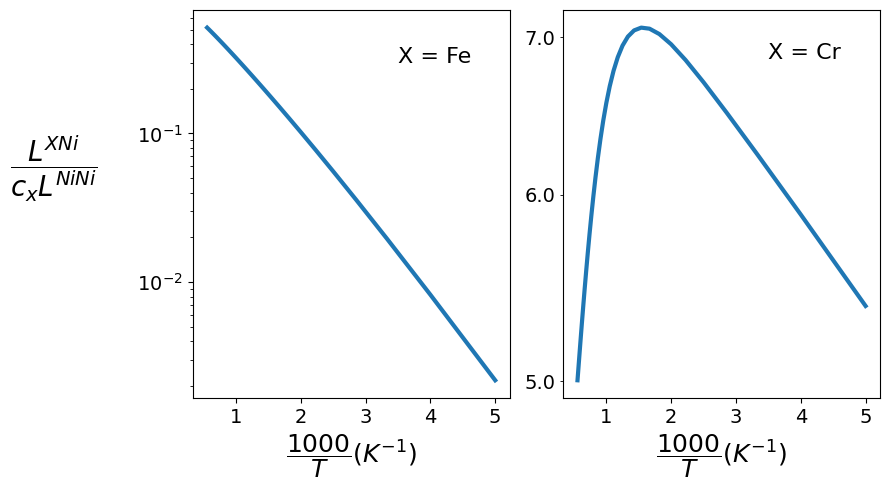

In [12]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9, 5))

ax1.semilogy(1000./T_arr, diff_ab_Fe/diff_bb_non_loc_Fe, label=r"$X = Fe$", linewidth=3, color="tab:blue")
ax1.set_xlabel(r'$\dfrac{1000}{T}(K^{-1})$', fontsize=18)
ax1.set_ylabel(r'$\dfrac{L^{XNi}}{c_xL^{NiNi}}$', fontsize=20, rotation = 0, labelpad = 60)
ax1.tick_params(labelsize=14)
ax1.text(3.5, 0.3, "X = Fe", fontsize=16)

ax2.semilogy(1000./T_arr, diff_ab_Cr/diff_bb_non_loc_Cr, label=r"$X = Cr$", linewidth=3, color="tab:blue")
ax2.set_xlabel(r'$\dfrac{1000}{T}(K^{-1})$', fontsize=18)
ax2.tick_params(which='both',labelsize=14)
ax2.yaxis.set_minor_formatter(ticker.ScalarFormatter())

ax2.text(3.5, 6.85, "X = Cr", fontsize=16)

plt.tight_layout()
plt.savefig("PDC_NiX.pdf", bbox_inches="tight", format="pdf")
plt.savefig("PDC_NiX.eps", bbox_inches="tight", format="eps")

## Next, we plot the drag ratios.

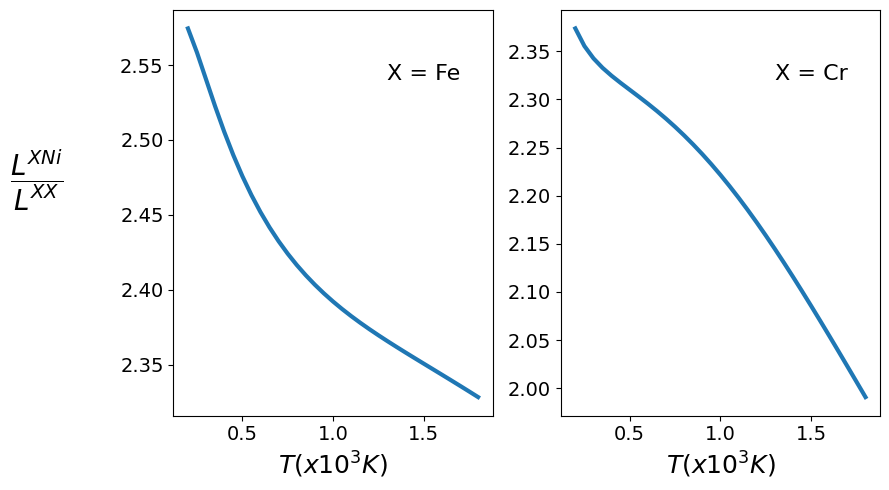

In [13]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9, 5))

ax1.plot(T_arr/1000., diff_ab_Fe/diff_aa_Fe, label=r"$X = Fe$", linewidth=3, color="tab:blue")
ax1.set_xlabel(r'$T(x10^3 K)$', fontsize=18)
ax1.set_ylabel(r'$\dfrac{L^{XNi}}{L^{XX}}$', fontsize=20, rotation = 0, labelpad = 60)
ax1.text(1.3, 2.54, r'X = Fe', fontsize=16)
ax1.tick_params(labelsize=14)

ax2.plot(T_arr/1000., diff_ab_Cr/diff_aa_Cr, label=r"$X = Cr$", linewidth=3, color="tab:blue")
ax2.set_xlabel(r'$T(x10^3 K)$', fontsize=18)
ax2.text(1.3, 2.32, r'X = Cr', fontsize=16)
ax2.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig("Drag_NiX.pdf", bbox_inches="tight", format="pdf")
plt.savefig("Drag_NiX.eps", bbox_inches="tight", format="eps")

# Next, we do the calculations without considering any electronic contributions

## First, the Cr system

In [14]:
vu0 = 4.48  # pure dumbbell jump attempt frequency
vu2 = 4.92  # mixed dumbbell jump attempt frequency

E_b_a = -0.11 # binding energy of a-type complex
E_b_b = -0.11 # binding energy of b-type complex
# Note - these barriers are not the same as in  Tucker et. al's paper - the barriers mentioned there do not
# satisfy detailed balance. This is was also addressed in Tucker's PhD thesis (see Table 3.15 there).
# We computed barriers that satisfy detailed balance while keeping migration barriers the same.
# Due to this discrepancy, we also don't consider electronic contributions to the formation and binding
# energies mentioned in Tucker et. al.

# Part 1: Energies and pre-factors of pure dumbbells.

# predb0 - pure dumbbell formation entropy
# enedb0 - pure dumbbell formation energy

# Note - there will be as many pure dumbbell energies and pre-factors as the
# number of lists in pdbcontainer.symorlist, since this is the number of symmetry unique dumbbells
# that can form.

predb0, enedb0 = np.ones(1)*np.exp(12.7), np.array([4.07])

# Part 2: The solute formation energy and prefactor
# all our energies are computed relative to the solute, we set it to zero energy.
preS, eneS = np.ones(1), np.zeros(1)


# Part 3: Here, we need to assign the appropriate binding energies to the solute dumbbell complexes we
# had identified earlier. For all the complexes, the binding energies are given in Table II of our GF paper.
# The first state is an origin state and its binding energy is set to zero.

preSdb, eneSdb = np.ones(3), np.array([0., E_b_a,E_b_b])

# Part 4: We add the mixed dumbbell binding energy to the pure dumbbell energy to get the mixed
# dumbbell formation energy.
predb2, enedb2 = np.ones(1), np.array([4.07 - 0.42])

# Next, put in the transition state energies of the jumps.

# Part 5: For omega0 jumps, the first type is roto-trans, the second is onsite rot.
# We add the migration barrier from Tucker et. al. to the pure dumbbell energy to get the transition state
# energy
eneT0 = np.array([4.07 + 0.14, 4.07 + 0.92])

# Part 6: For omega2 jumps, the first type is roto-trans, the second is onsite rot.
# We add the migration barrier from Tucker et. al. to the MIXED dumbbell energy to get the transition state
# energy. Note that in the case of Cr, the mixed dumbbell energy is 4.07 - 0.42.
eneT2 = np.array([4.07 - 0.42 + 0.08, 4.07 - 0.42 + 0.75])

# Part 7: For the omega4-3 jumps, we add the omega3 migration barrier to the mixed dumbbell formation
# energy to get the transition state energy.
eneT43 = np.array([4.07 - 0.42 + 0.31])

# Part 8: The omega1 jump barriers

# Here we assign the Transition state energies to the jump types we had identified earlier.
eneT1 = np.zeros(len(onsagercalculator.jnet1))

# from 14 to 25, we have on-site rotations - we assign the pure dumbbell
# rotation transition state energies since no other values we indicated.
eneT1[14:] = 4.07 + 0.92

# Now, the roto-translation transition state energies.
# These are assigned in the following manner: We have already identified in the previous cells which jumps in
# our omega1 jump network corresponds to which type of jump in Tucker et. al.
# We now add the corresponding migration barrier (from Tucker et. al.) to the formation energies of
# the initial states of the corresponding jumps to get their transition state energies.
eneT1[8:13] = 4.07 + 0.14

eneT1[1] = 4.07 + E_b_a + 0.26
eneT1[2] = 4.07 + E_b_a + 0.26
eneT1[3] = np.inf # This is set to infinity in Tucker et. al.
eneT1[4] = 4.07 + E_b_b + 0.16
eneT1[5] = 4.07 + E_b_b + 0.21
eneT1[6] = 4.07 + E_b_a + 0.26
eneT1[7] = 4.07 + E_b_a + 0.26

# Next, make arrays to store transport coefficients
# diff_aa_Cr : solute-solute (Cr-Cr) transport coefficient
# diff_ab_Cr : solute-solvent (Cr-Ni) transport coefficient
# diff_bb_non_loc_Cr : bare Ni-Ni dumbbell diffusivity.
# diff_ab_Cr : solvent-solvent (Ni-Ni) transport coefficient - correction term due to
# solute-solvent interaction

diff_aa_Cr_No_EC = np.zeros(len(T_arr))
diff_ab_Cr_No_EC = np.zeros(len(T_arr))
diff_bb_Cr_No_EC = np.zeros(len(T_arr))

diff_bb_non_loc_Cr_No_EC = np.zeros(len(T_arr))

# Multipliers to pre-fractors
# Every Ni hop is a w0 hop and will use TS0 and OL0 for migration barrier

# NOTE - ELECTRONIC CONTRIBUTIONS TO ENERGIES HAVE BEEN NEGLECTED.
TS0 = 209.15
OL0 = 209.51

# These values are taken from Table D.4 in Tucker et. al's paper.
TS = 206.88
OL = 204.79

# Ignore all electronic parts
preT0 = Dconv*vu0*np.ones(len(onsagercalculator.jnet0)) #*np.exp(multNi)
preT1 = Dconv*vu0*np.ones(len(onsagercalculator.jnet1)) #*np.exp(multNi)
preT43 = Dconv*vu0*np.ones(len(onsagercalculator.jnet43)) #*np.exp(multNi)    
preT2 = Dconv*vu2*np.ones(len(onsagercalculator.jnet2)) #*np.exp(m*(TS - OL))

for i in tqdm(range(T_arr.shape[0]), position=0, leave=True, ncols=65):
    T = T_arr[i]
    kT = kB*T
    
    # convert the formation energies, Transition state energies and and pre-factors to beta(1/kT)*Free energy
    bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
        onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                               preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)
    
    # Next, Get the transport coefficients
    L0bb, (L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
    onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)
    
    # Add the correlated and uncorrelated parts to get the total transport coefficient.
    L_aa = L_uc_aa + L_c_aa
    L_bb = L_uc_bb + L_c_bb
    L_ab = L_uc_ab + L_c_ab
    
    diff_aa_Cr_No_EC[i] = L_aa[0][0]
    diff_bb_Cr_No_EC[i] = L_bb[0][0]
    diff_ab_Cr_No_EC[i] = L_ab[0][0]
    
    diff_bb_non_loc_Cr_No_EC[i] = L0bb[0][0]  # The bare dumbbell diffusivity

100%|████████████████████████████| 33/33 [00:37<00:00,  1.13s/it]


## Next the Ni-Fe system

In [15]:
# 1.  First get the rates and thermodynamic data
vu0 = 4.48
vu2 = 4.14

E_b_a = 0.06 # binding energy of a-type complex
E_b_b = -0.02 # binding energy of b-type complex

# Pure dumbbell Energies and pre-factors
predb0, enedb0 = np.ones(1)*np.exp(12.7), np.array([4.07])

preS, eneS = np.ones(1), np.zeros(1)

# Next, binding energies and pre-factors for solutes-dumbbell complex states.
# The first state is the origin state, the second one is AA(perp)B (b-type) and the last is AA(||)B (a-type)
preSdb, eneSdb = np.ones(3), np.array([0., E_b_a, E_b_b])

# Next, binding energies of mixed dumbbells.
predb2, enedb2 = np.ones(1), np.array([4.07 + 0.11])

# Transition state energies of omega0 jumps
eneT0 = np.array([4.07 + 0.14, 4.07 + 0.92])

# Transition state energies of omega2 jumps
eneT2 = np.array([4.07 + 0.11 + 0.11, 4.07 + 0.11 + 0.87])

# Transition state energies of omega43 jumps
eneT43 = np.array([4.07 + 0.11 + 0.15])


# For omega1, we first need to set rotation rates
# All rotations are assumed to be with the same rate as bare dumbbell rotations (they are high energy paths 
# anyway)

preT1 = Dconv*vu0*np.ones(len(onsagercalculator.jnet1))

eneT1 = np.zeros(len(onsagercalculator.jnet1))
# from 14 to 25, we have on-site rotations
eneT1[14:] = 4.07 + 0.92
# Now, the roto-translation rates without interactions
eneT1[8:13] = 4.07 + 0.14

eneT1[1] = 4.07 + E_b_a + 0.14
eneT1[2] = 4.07 + E_b_a + 0.14
eneT1[3] = 4.07 + E_b_a + 0.16
eneT1[4] = 4.07 + E_b_b + 0.15
eneT1[5] = 4.07 + E_b_b + 0.17
eneT1[6] = 4.07 + E_b_a + 0.14
eneT1[7] = 4.07 + E_b_a + 0.14



diff_aa_Fe_No_EC = np.zeros(len(T_arr))
diff_bb_Fe_No_EC = np.zeros(len(T_arr))
diff_ab_Fe_No_EC = np.zeros(len(T_arr))
diff_bb_non_loc_Fe_No_EC = np.zeros(len(T_arr))


# Every Ni hop is a w0 hop and will use TS0 and OL0 for migration barrier
TS0 = 209.15
OL0 = 209.51

TS = 206.09
OL = 206.85

# Ignore all electronic parts
preT0 = Dconv*vu0*np.ones(len(onsagercalculator.vkinetic.starset.jnet0))
preT1 = Dconv*vu0*np.ones(len(onsagercalculator.jnet1))
preT43 = Dconv*vu0*np.ones(len(onsagercalculator.jnet43))
preT2 = Dconv*vu2*np.ones(len(onsagercalculator.jnet2))

for i in tqdm(range(T_arr.shape[0]), position=0, leave=True, ncols=65):
    T = T_arr[i]
    kT = kB*T
    
    bFdb0, bFdb2, bFS, bFSdb, bFT0, bFT1, bFT2, bFT3, bFT4 = \
        onsagercalculator.preene2betafree(kT, predb0, enedb0, preS, eneS, preSdb, eneSdb, predb2, enedb2,
                                               preT0, eneT0, preT2, eneT2, preT1, eneT1, preT43, eneT43)

    L0bb, (L_uc_aa,L_c_aa), (L_uc_bb,L_c_bb), (L_uc_ab,L_c_ab)=\
    onsagercalculator.L_ij(bFdb0, bFT0, bFdb2, bFT2, bFS, bFSdb, bFT1, bFT3, bFT4)
    
    L_aa = L_uc_aa + L_c_aa
    L_bb = L_uc_bb + L_c_bb
    L_ab = L_uc_ab + L_c_ab
    
    diff_aa_Fe_No_EC[i] = L_aa[0][0]
    diff_bb_Fe_No_EC[i] = L_bb[0][0]
    diff_ab_Fe_No_EC[i] = L_ab[0][0]
    diff_bb_non_loc_Fe_No_EC[i] = L0bb[0][0]

100%|████████████████████████████| 33/33 [00:36<00:00,  1.11s/it]


## Next, we plot the Partial Diffusion Coefficient (PDC) Ratios</br> without electronic parts

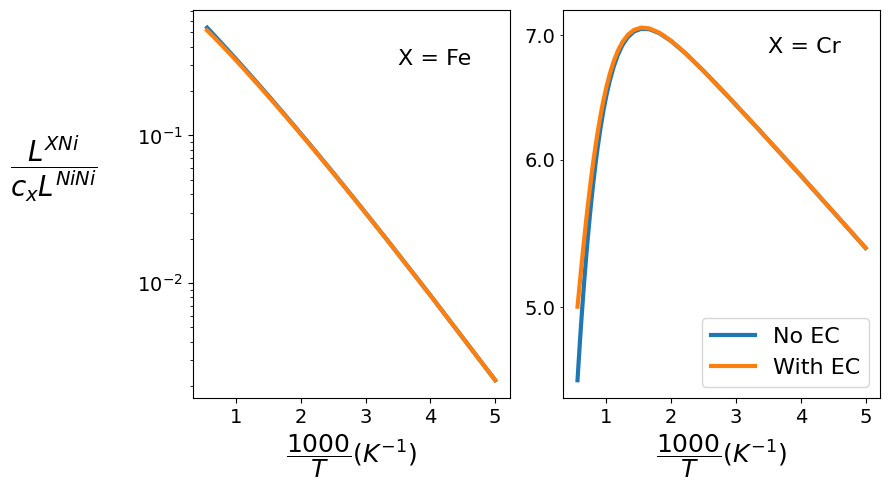

In [16]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9, 5))

ax1.semilogy(1000./T_arr, diff_ab_Fe_No_EC/diff_bb_non_loc_Fe_No_EC,
             linewidth=3, color="tab:blue", label="No EC")
ax1.semilogy(1000./T_arr, diff_ab_Fe/diff_bb_non_loc_Fe, linewidth=3, color="tab:orange",
            label="With EC")
ax1.set_xlabel(r'$\dfrac{1000}{T}(K^{-1})$', fontsize=18)
ax1.set_ylabel(r'$\dfrac{L^{XNi}}{c_xL^{NiNi}}$', fontsize=20, rotation = 0, labelpad = 60)
ax1.tick_params(labelsize=14)
ax1.text(3.5, 0.3, "X = Fe", fontsize=16)

ax2.semilogy(1000./T_arr, diff_ab_Cr_No_EC/diff_bb_non_loc_Cr_No_EC,
             linewidth=3, color="tab:blue", label="No EC")
ax2.semilogy(1000./T_arr, diff_ab_Cr/diff_bb_non_loc_Cr, linewidth=3, color="tab:orange",
            label="With EC")
ax2.set_xlabel(r'$\dfrac{1000}{T}(K^{-1})$', fontsize=18)
ax2.tick_params(which='both',labelsize=14)
ax2.yaxis.set_minor_formatter(ticker.ScalarFormatter())

ax2.text(3.5, 6.85, "X = Cr", fontsize=16)

plt.tight_layout()
ax2.legend(loc="lower right", fontsize=16)

## Next, we plot the Drag (PDC) Ratios</br> without electronic parts

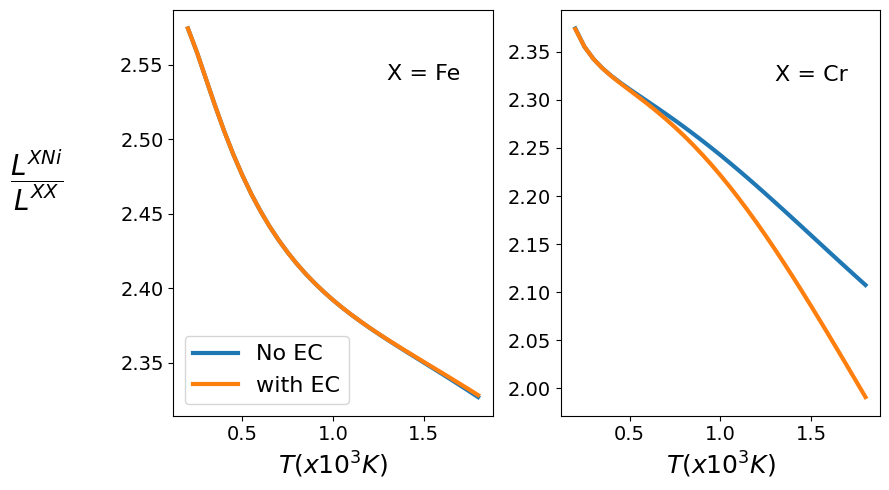

In [17]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9, 5))

ax1.plot(T_arr/1000., diff_ab_Fe_No_EC/diff_aa_Fe_No_EC, label="No EC", linewidth=3, color="tab:blue")
ax1.plot(T_arr/1000., diff_ab_Fe/diff_aa_Fe, linewidth=3, color="tab:orange",
        label="with EC")
ax1.set_xlabel(r'$T(x10^3 K)$', fontsize=18)
ax1.set_ylabel(r'$\dfrac{L^{XNi}}{L^{XX}}$', fontsize=20, rotation = 0, labelpad = 60)
ax1.text(1.3, 2.54, r'X = Fe', fontsize=16)
ax1.tick_params(labelsize=14)
# ax1.title.set_text(r"$X = Fe$")
ax1.legend(loc="lower left", fontsize=16)

ax2.plot(T_arr/1000., diff_ab_Cr_No_EC/diff_aa_Cr_No_EC, label=r"No EC", linewidth=3, color="tab:blue")
ax2.plot(T_arr/1000., diff_ab_Cr/diff_aa_Cr, label=r"with EC", linewidth=3, color="tab:orange")
ax2.set_xlabel(r'$T(x10^3 K)$', fontsize=18)
ax2.text(1.3, 2.32, r'X = Cr', fontsize=16)
ax2.tick_params(labelsize=14)
# ax2.title.set_text(r"$X = Cr$")

plt.tight_layout()

With or without the electronic parts, the trends are the same and even the values change at the first decimal place only at high temperatures. As such, we conclude that the rate electronic parts were not very significant in terms of the drag and pdc ratios.

Note however, that due to discrepancies found in binding energies, we did not consider the electronic contributions to the binding energies.